# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
# sort dfdata based on longitude
dfdata = dfdata.sort_values("longitude")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
5962,-180,38,4,-5425.0,NaN,5.702333,NaN,427.678925,34.342628,NaN,15.691460
5757,-180,39,4,-5335.0,NaN,5.829761,NaN,497.673096,34.254448,NaN,14.695810
32077,-180,-55,4,-5287.0,NaN,6.456027,NaN,335.052032,34.125984,NaN,6.751073
5562,-180,40,4,-5241.0,NaN,5.968406,NaN,584.339844,34.158997,NaN,13.663589


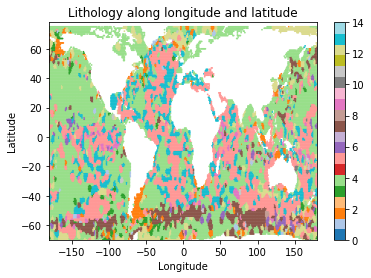

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

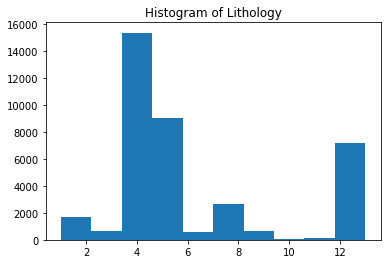

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    plt.hist(y)
    plt.title(title)
    plt.show()

draw_hist(y, "Histogram of Lithology")

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.

In [4]:
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, Model
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
warnings.simplefilter("ignore")

Using TensorFlow backend.


### Data preprocessing
* Normalize features X
* Onehot multiclass target Y

In [5]:
# obtain list of feature names
training_data = dfdata.copy()
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# extract X and Y
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

### Construct neural network
The neural network has the following structure:
- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Output layer

In [6]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# parameters for hidden layers
activation = "relu"
dropout_ratio = 0.1
initializer = "random_uniform"
dropout_ratio = 0.2
numclass = dummy_Y.shape[1]
N, d = X.shape

# construct layers
inputs = Input(shape=(d,))
layer = Dense(64, activation=activation, kernel_initializer=initializer)(inputs)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(64, activation=activation, kernel_initializer=initializer)(layer)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(32, activation=activation, kernel_initializer=initializer)(layer)
prediction = Dense(numclass, activation="softmax")(layer)

# create model
model = Model(inputs=inputs, outputs=prediction)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 13)                429       
Total para

In [7]:
# parameters for training
epochs = 200
batch_size = 3
verbose = True

# use 5 fold cross validation without shuffle
kfold = KFold(n_splits=5, random_state=seed)

# training
prediction = np.zeros((N, numclass))
for train_ind, test_ind in kfold.split(X):
    train_X, train_Y = X[train_ind], dummy_Y[train_ind]
    model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=weight)
    mu = model.predict(X[test_ind])
    prediction[test_ind, :] = mu

Epoch 1/200
30439/30439 [==============================] - 10s 341us/step - loss: 1.4987 - acc: 0.4690
Epoch 2/200
30439/30439 [==============================] - 10s 327us/step - loss: 1.4203 - acc: 0.5035
Epoch 3/200
30439/30439 [==============================] - 10s 325us/step - loss: 1.3932 - acc: 0.5093
Epoch 4/200
30439/30439 [==============================] - 10s 325us/step - loss: 1.3742 - acc: 0.5169
Epoch 5/200
30439/30439 [==============================] - 10s 325us/step - loss: 1.3649 - acc: 0.5187
Epoch 6/200
30439/30439 [==============================] - 10s 322us/step - loss: 1.3493 - acc: 0.5232
Epoch 7/200
30439/30439 [==============================] - 10s 320us/step - loss: 1.3405 - acc: 0.5254
Epoch 8/200
30439/30439 [==============================] - 10s 318us/step - loss: 1.3354 - acc: 0.5243
Epoch 9/200
30439/30439 [==============================] - 10s 320us/step - loss: 1.3287 - acc: 0.5290
Epoch 10/200
30439/30439 [==============================] - 10s 315us/ste

30439/30439 [==============================] - 10s 327us/step - loss: 1.2465 - acc: 0.5538
Epoch 80/200
30439/30439 [==============================] - 10s 328us/step - loss: 1.2519 - acc: 0.5488
Epoch 81/200
30439/30439 [==============================] - 10s 328us/step - loss: 1.2483 - acc: 0.5510
Epoch 82/200
30439/30439 [==============================] - 10s 320us/step - loss: 1.2432 - acc: 0.5533
Epoch 83/200
30439/30439 [==============================] - 10s 316us/step - loss: 1.2478 - acc: 0.5507
Epoch 84/200
30439/30439 [==============================] - 10s 317us/step - loss: 1.2499 - acc: 0.5523
Epoch 85/200
30439/30439 [==============================] - 10s 314us/step - loss: 1.2456 - acc: 0.5521
Epoch 86/200
30439/30439 [==============================] - 10s 315us/step - loss: 1.2450 - acc: 0.5499
Epoch 87/200
30439/30439 [==============================] - 10s 317us/step - loss: 1.2470 - acc: 0.5525
Epoch 88/200
30439/30439 [==============================] - 10s 318us/step - 

30439/30439 [==============================] - 10s 340us/step - loss: 1.2497 - acc: 0.5597
Epoch 158/200
30439/30439 [==============================] - 10s 316us/step - loss: 1.2465 - acc: 0.5591
Epoch 159/200
30439/30439 [==============================] - 10s 324us/step - loss: 1.2484 - acc: 0.5578
Epoch 160/200
30439/30439 [==============================] - 10s 318us/step - loss: 1.2472 - acc: 0.5576
Epoch 161/200
30439/30439 [==============================] - 10s 318us/step - loss: 1.2532 - acc: 0.5540
Epoch 162/200
30439/30439 [==============================] - 10s 328us/step - loss: 1.2501 - acc: 0.5594
Epoch 163/200
30439/30439 [==============================] - 10s 323us/step - loss: 1.2483 - acc: 0.5573
Epoch 164/200
30439/30439 [==============================] - 10s 329us/step - loss: 1.2488 - acc: 0.5557
Epoch 165/200
30439/30439 [==============================] - 10s 325us/step - loss: 1.2466 - acc: 0.5580
Epoch 166/200
30439/30439 [==============================] - 10s 328u

30439/30439 [==============================] - 10s 329us/step - loss: 1.2395 - acc: 0.5786
Epoch 36/200
30439/30439 [==============================] - 10s 337us/step - loss: 1.2375 - acc: 0.5762
Epoch 37/200
30439/30439 [==============================] - 10s 341us/step - loss: 1.2362 - acc: 0.5731
Epoch 38/200
30439/30439 [==============================] - 11s 350us/step - loss: 1.2339 - acc: 0.5753
Epoch 39/200
30439/30439 [==============================] - 11s 345us/step - loss: 1.2418 - acc: 0.5757
Epoch 40/200
30439/30439 [==============================] - 10s 320us/step - loss: 1.2361 - acc: 0.5738
Epoch 41/200
30439/30439 [==============================] - 10s 333us/step - loss: 1.2356 - acc: 0.5765
Epoch 42/200
30439/30439 [==============================] - 11s 347us/step - loss: 1.2413 - acc: 0.5770
Epoch 43/200
30439/30439 [==============================] - 11s 349us/step - loss: 1.2430 - acc: 0.5767
Epoch 44/200
30439/30439 [==============================] - 11s 351us/step - 

30439/30439 [==============================] - 11s 349us/step - loss: 1.2347 - acc: 0.5769
Epoch 114/200
30439/30439 [==============================] - 10s 331us/step - loss: 1.2356 - acc: 0.5766
Epoch 115/200
30439/30439 [==============================] - 10s 332us/step - loss: 1.2304 - acc: 0.5793
Epoch 116/200
30439/30439 [==============================] - 10s 323us/step - loss: 1.2303 - acc: 0.5797
Epoch 117/200
30439/30439 [==============================] - 10s 336us/step - loss: 1.2232 - acc: 0.5817
Epoch 118/200
30439/30439 [==============================] - 10s 318us/step - loss: 1.2249 - acc: 0.5779
Epoch 119/200
30439/30439 [==============================] - 10s 338us/step - loss: 1.2222 - acc: 0.5817
Epoch 120/200
30439/30439 [==============================] - 10s 334us/step - loss: 1.2367 - acc: 0.5780
Epoch 121/200
30439/30439 [==============================] - 10s 335us/step - loss: 1.2273 - acc: 0.5789
Epoch 122/200
30439/30439 [==============================] - 10s 340u

30439/30439 [==============================] - 11s 348us/step - loss: 1.2346 - acc: 0.5823
Epoch 192/200
30439/30439 [==============================] - 11s 353us/step - loss: 1.2391 - acc: 0.5781
Epoch 193/200
30439/30439 [==============================] - 11s 350us/step - loss: 1.2331 - acc: 0.5795
Epoch 194/200
30439/30439 [==============================] - 10s 345us/step - loss: 1.2346 - acc: 0.5795
Epoch 195/200
30439/30439 [==============================] - 11s 349us/step - loss: 1.2283 - acc: 0.5812
Epoch 196/200
30439/30439 [==============================] - 11s 349us/step - loss: 1.2338 - acc: 0.5786
Epoch 197/200
30439/30439 [==============================] - 11s 348us/step - loss: 1.2372 - acc: 0.5806
Epoch 198/200
30439/30439 [==============================] - 11s 348us/step - loss: 1.2292 - acc: 0.5791
Epoch 199/200
30439/30439 [==============================] - 11s 349us/step - loss: 1.2456 - acc: 0.5783
Epoch 200/200
30439/30439 [==============================] - 11s 350u

30439/30439 [==============================] - 10s 344us/step - loss: 1.2562 - acc: 0.5755
Epoch 70/200
30439/30439 [==============================] - 11s 353us/step - loss: 1.2587 - acc: 0.5748
Epoch 71/200
30439/30439 [==============================] - 11s 353us/step - loss: 1.2573 - acc: 0.5751
Epoch 72/200
30439/30439 [==============================] - 11s 348us/step - loss: 1.2577 - acc: 0.5765
Epoch 73/200
30439/30439 [==============================] - 11s 352us/step - loss: 1.2733 - acc: 0.5751
Epoch 74/200
30439/30439 [==============================] - 11s 353us/step - loss: 1.2628 - acc: 0.5751
Epoch 75/200
30439/30439 [==============================] - 11s 349us/step - loss: 1.2727 - acc: 0.5738
Epoch 76/200
30439/30439 [==============================] - 11s 351us/step - loss: 1.2672 - acc: 0.5762
Epoch 77/200
30439/30439 [==============================] - 11s 351us/step - loss: 1.2651 - acc: 0.5771
Epoch 78/200
30439/30439 [==============================] - 11s 350us/step - 

30439/30439 [==============================] - 11s 350us/step - loss: 1.2508 - acc: 0.5796
Epoch 148/200
30439/30439 [==============================] - 11s 351us/step - loss: 1.2595 - acc: 0.5790
Epoch 149/200
30439/30439 [==============================] - 11s 353us/step - loss: 1.2611 - acc: 0.5750
Epoch 150/200
30439/30439 [==============================] - 11s 351us/step - loss: 1.2611 - acc: 0.5788
Epoch 151/200
30439/30439 [==============================] - 10s 335us/step - loss: 1.2599 - acc: 0.5763
Epoch 152/200
30439/30439 [==============================] - 11s 351us/step - loss: 1.2616 - acc: 0.5760
Epoch 153/200
30439/30439 [==============================] - 11s 352us/step - loss: 1.2725 - acc: 0.5742
Epoch 154/200
30439/30439 [==============================] - 11s 351us/step - loss: 1.2546 - acc: 0.5779
Epoch 155/200
30439/30439 [==============================] - 11s 351us/step - loss: 1.2612 - acc: 0.5725
Epoch 156/200
30439/30439 [==============================] - 11s 350u

30439/30439 [==============================] - 10s 334us/step - loss: 1.2616 - acc: 0.5665
Epoch 26/200
30439/30439 [==============================] - 11s 351us/step - loss: 1.2665 - acc: 0.5637
Epoch 27/200
30439/30439 [==============================] - 13s 421us/step - loss: 1.2559 - acc: 0.5639
Epoch 28/200
30439/30439 [==============================] - 10s 344us/step - loss: 1.2610 - acc: 0.5663
Epoch 29/200
30439/30439 [==============================] - 11s 348us/step - loss: 1.2559 - acc: 0.5648
Epoch 30/200
30439/30439 [==============================] - 10s 343us/step - loss: 1.2598 - acc: 0.5665
Epoch 31/200
30439/30439 [==============================] - 11s 349us/step - loss: 1.2626 - acc: 0.5672
Epoch 32/200
30439/30439 [==============================] - 10s 323us/step - loss: 1.2582 - acc: 0.5667
Epoch 33/200
30439/30439 [==============================] - 11s 349us/step - loss: 1.2587 - acc: 0.5639
Epoch 34/200
30439/30439 [==============================] - 11s 354us/step - 

KeyboardInterrupt: 

### Validate

In [ ]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values

mean = np.argmax(prediction, axis=1)
print("Accuracy = {}".format(accuracy_score(Y, mean)))
draw_hist(Y + 1, "Histogram of Actual lithology")
draw_hist(mean + 1, "Histogram of Predicted lithology")
draw_global(lon, lat, Y + 1, "Actual lithology")
draw_global(lon, lat, mean + 1, "Predicted lithology")

In [ ]:
def draw_prob(lon, lat, p, title, size=3):
    sc = plt.scatter(lon, lat, s=size, c=p)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
    plt.close()
    
for i in range(13):
    common_part = "Lithology label {}".format(i + 1)
    title_p = "Predicted probablity distribution of {}".format(common_part)
    title_y = "Actual {}".format(common_part)
    # find Y_ts whose label is i + 1 and plot
    index = Y == i
    thisY = Y[Y == i] + 1
    draw_global(lon[index], lat[index], y=thisY, title=title_y)
    # plot prob distribution
    draw_prob(lon, lat, p = prediction[:,i], title=title_p)